In [23]:
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# Text analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb

# Download NLTK data
try:
    nltk.data.find('vader_lexicon')
    nltk.data.find('punkt')
except LookupError:
    nltk.download('vader_lexicon')
    nltk.download('punkt')

print("✅ All imports successful!")

✅ All imports successful!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
BASE_PATH = '/kaggle/input/fake-or-real-the-impostor-hunt/data'
TRAIN_CSV = f'{BASE_PATH}/train.csv'
TRAIN_DIR = f'{BASE_PATH}/train'  # Contains article_XXXX subdirectories
TEST_DIR = f'{BASE_PATH}/test'    # Contains article_XXXX subdirectories
SUBMISSION_FILE = 'submission.csv'

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"📁 Base path: {BASE_PATH}")
print(f"📋 Training CSV: {TRAIN_CSV}")
print(f"📁 Training dir: {TRAIN_DIR}")
print(f"📁 Test dir: {TEST_DIR}")

📁 Base path: /kaggle/input/fake-or-real-the-impostor-hunt/data
📋 Training CSV: /kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv
📁 Training dir: /kaggle/input/fake-or-real-the-impostor-hunt/data/train
📁 Test dir: /kaggle/input/fake-or-real-the-impostor-hunt/data/test


In [25]:
def explore_data_structure():
    """Explore the actual Kaggle data structure"""
    print("🔍 Exploring Kaggle data structure...")
    
    # Check CSV file
    if os.path.exists(TRAIN_CSV):
        df = pd.read_csv(TRAIN_CSV)
        print(f"📊 Training CSV shape: {df.shape}")
        print(f"📊 Training CSV columns: {df.columns.tolist()}")
        print(f"📊 Sample rows:")
        print(df.head())
        print(f"📊 Article ID range: {df['id'].min()} to {df['id'].max()}")
        print(f"📊 Real text distribution: {df['real_text_id'].value_counts().to_dict()}")
    else:
        print(f"❌ Training CSV not found: {TRAIN_CSV}")
        return None
    
    # Check train directory structure
    if os.path.exists(TRAIN_DIR):
        subdirs = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
        print(f"📁 Training subdirectories: {len(subdirs)}")
        print(f"📁 First 10 subdirs: {sorted(subdirs)[:10]}")
        
        # Check a sample subdirectory
        if subdirs:
            sample_dir = os.path.join(TRAIN_DIR, subdirs[0])
            files = os.listdir(sample_dir)
            print(f"📄 Files in {subdirs[0]}: {files}")
    else:
        print(f"❌ Training directory not found: {TRAIN_DIR}")
    
    # Check test directory structure  
    if os.path.exists(TEST_DIR):
        subdirs = [d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))]
        print(f"📁 Test subdirectories: {len(subdirs)}")
        print(f"📁 First 10 test subdirs: {sorted(subdirs)[:10]}")
    else:
        print(f"❌ Test directory not found: {TEST_DIR}")
    
    return df

# Run initial exploration
df_info = explore_data_structure()

🔍 Exploring Kaggle data structure...
📊 Training CSV shape: (95, 2)
📊 Training CSV columns: ['id', 'real_text_id']
📊 Sample rows:
   id  real_text_id
0   0             1
1   1             2
2   2             1
3   3             2
4   4             2
📊 Article ID range: 0 to 94
📊 Real text distribution: {2: 49, 1: 46}
📁 Training subdirectories: 95
📁 First 10 subdirs: ['article_0000', 'article_0001', 'article_0002', 'article_0003', 'article_0004', 'article_0005', 'article_0006', 'article_0007', 'article_0008', 'article_0009']
📄 Files in article_0026: ['file_2.txt', 'file_1.txt']
📁 Test subdirectories: 1068
📁 First 10 test subdirs: ['article_0000', 'article_0001', 'article_0002', 'article_0003', 'article_0004', 'article_0005', 'article_0006', 'article_0007', 'article_0008', 'article_0009']


In [26]:
class TextAuthenticityAnalyzer:
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()
    
    def load_data(self, train_dir, train_csv_path):
        """Load training data from Kaggle structure: train/article_XXXX/file_1.txt, file_2.txt"""
        print(f"📖 Loading data from {train_dir} and {train_csv_path}")
        
        if not os.path.exists(train_csv_path):
            raise FileNotFoundError(f"Training CSV not found: {train_csv_path}")
        
        train_df = pd.read_csv(train_csv_path)
        print(f"📊 Found {len(train_df)} training samples in CSV")
        
        texts_data = []
        missing_files = 0
        
        for idx, row in train_df.iterrows():
            article_id = row['id']
            real_text_id = row['real_text_id']
            
            # Create paths for Kaggle structure: train/article_XXXX/file_1.txt, file_2.txt
            article_dir = os.path.join(train_dir, f"article_{article_id:04d}")
            text_1_path = os.path.join(article_dir, "file_1.txt")
            text_2_path = os.path.join(article_dir, "file_2.txt")
            
            if os.path.exists(text_1_path) and os.path.exists(text_2_path):
                try:
                    with open(text_1_path, 'r', encoding='utf-8') as f:
                        text_1 = f.read().strip()
                    with open(text_2_path, 'r', encoding='utf-8') as f:
                        text_2 = f.read().strip()
                    
                    texts_data.append({
                        'article_id': article_id,
                        'text_1': text_1,
                        'text_2': text_2,
                        'real_text_id': real_text_id,
                        'real_text': text_1 if real_text_id == 1 else text_2,
                        'fake_text': text_2 if real_text_id == 1 else text_1
                    })
                except Exception as e:
                    print(f"❌ Error reading files for article {article_id}: {e}")
                    missing_files += 1
            else:
                print(f"❌ Missing files for article {article_id} at {article_dir}")
                missing_files += 1
                
                if idx < 5:  # Show details for first few missing files
                    print(f"  Expected: {text_1_path}")
                    print(f"  Exists: {os.path.exists(text_1_path)}")
                    print(f"  Expected: {text_2_path}")
                    print(f"  Exists: {os.path.exists(text_2_path)}")
        
        if missing_files > 0:
            print(f"⚠️  {missing_files} files could not be loaded")
        
        df = pd.DataFrame(texts_data)
        print(f"✅ Successfully loaded {len(df)} text pairs")
        return df
    
    def extract_linguistic_features(self, text):
        """Extract comprehensive linguistic features from text"""
        features = {}
        
        if not text or len(text.strip()) == 0:
            # Return default features for empty text
            return {f: 0 for f in ['length', 'word_count', 'sentence_count', 'avg_word_length', 
                                  'avg_sentence_length', 'flesch_reading_ease', 'flesch_kincaid_grade',
                                  'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_compound',
                                  'exclamation_count', 'question_count', 'comma_count', 'semicolon_count',
                                  'colon_count', 'quotation_count', 'capital_ratio', 'digit_ratio',
                                  'most_frequent_word_ratio', 'unique_word_ratio', 'space_term_ratio']}
        
        # Basic statistics
        features['length'] = len(text)
        words = text.split()
        features['word_count'] = len(words)
        sentences = re.split(r'[.!?]+', text.strip())
        sentences = [s.strip() for s in sentences if s.strip()]
        features['sentence_count'] = len(sentences) if sentences else 1
        
        if words:
            features['avg_word_length'] = np.mean([len(word) for word in words])
        else:
            features['avg_word_length'] = 0
            
        features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)
        
        # Readability scores (handle potential errors)
        try:
            features['flesch_reading_ease'] = flesch_reading_ease(text)
        except:
            features['flesch_reading_ease'] = 0
            
        try:
            features['flesch_kincaid_grade'] = flesch_kincaid_grade(text)
        except:
            features['flesch_kincaid_grade'] = 0
        
        # Sentiment analysis
        sentiment = self.sia.polarity_scores(text)
        features['sentiment_pos'] = sentiment['pos']
        features['sentiment_neg'] = sentiment['neg']
        features['sentiment_neu'] = sentiment['neu']
        features['sentiment_compound'] = sentiment['compound']
        
        # Punctuation and special characters
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['comma_count'] = text.count(',')
        features['semicolon_count'] = text.count(';')
        features['colon_count'] = text.count(':')
        features['quotation_count'] = text.count('"') + text.count("'")
        
        # Capital letters and formatting
        total_chars = len(text)
        if total_chars > 0:
            features['capital_ratio'] = sum(1 for c in text if c.isupper()) / total_chars
            features['digit_ratio'] = sum(1 for c in text if c.isdigit()) / total_chars
        else:
            features['capital_ratio'] = 0
            features['digit_ratio'] = 0
        
        # Word frequency patterns (potential hallucination indicators)
        if words:
            words_lower = [w.lower() for w in words]
            word_freq = Counter(words_lower)
            features['most_frequent_word_ratio'] = max(word_freq.values()) / len(words)
            features['unique_word_ratio'] = len(set(words_lower)) / len(words)
        else:
            features['most_frequent_word_ratio'] = 0
            features['unique_word_ratio'] = 0
        
        # Space-related terms (domain-specific)
        space_terms = ['space', 'satellite', 'orbit', 'mission', 'spacecraft', 'astronaut', 
                      'telescope', 'planet', 'solar', 'cosmic', 'research', 'experiment',
                      'esa', 'nasa', 'observatory', 'launch', 'rocket', 'mars', 'earth',
                      'astronomy', 'astrophysics', 'galaxy', 'universe', 'station']
        
        if words:
            words_lower = [w.lower() for w in words]
            space_term_count = sum(1 for word in words_lower 
                                 if any(term in word for term in space_terms))
            features['space_term_ratio'] = space_term_count / len(words)
        else:
            features['space_term_ratio'] = 0
        
        return features
    
    def extract_semantic_features(self, text1, text2):
        """Extract features comparing two texts"""
        features = {}
        
        if not text1 or not text2:
            return {'tfidf_similarity': 0, 'word_overlap_ratio': 0, 
                   'length_diff': 0, 'length_ratio': 0}
        
        # TF-IDF similarity
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        try:
            tfidf_matrix = vectorizer.fit_transform([text1, text2])
            features['tfidf_similarity'] = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        except:
            features['tfidf_similarity'] = 0
        
        # Word overlap
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        if words1 or words2:
            features['word_overlap_ratio'] = len(words1.intersection(words2)) / len(words1.union(words2))
        else:
            features['word_overlap_ratio'] = 0
        
        # Length comparison
        len1, len2 = len(text1), len(text2)
        features['length_diff'] = abs(len1 - len2)
        if max(len1, len2) > 0:
            features['length_ratio'] = min(len1, len2) / max(len1, len2)
        else:
            features['length_ratio'] = 1
        
        return features
    
    def analyze_dataset(self, df):
        """Perform comprehensive analysis of the dataset"""
        print("🔍 Analyzing dataset features...")
        
        if len(df) == 0:
            print("❌ No data to analyze!")
            return None, None, None, None
        
        # Extract features for all texts
        real_features = []
        fake_features = []
        pair_features = []
        
        for idx, row in df.iterrows():
            if idx % 10 == 0:
                print(f"  Processing sample {idx+1}/{len(df)}")
                
            real_feat = self.extract_linguistic_features(row['real_text'])
            fake_feat = self.extract_linguistic_features(row['fake_text'])
            pair_feat = self.extract_semantic_features(row['real_text'], row['fake_text'])
            
            real_features.append({**real_feat, 'type': 'real'})
            fake_features.append({**fake_feat, 'type': 'fake'})
            pair_features.append(pair_feat)
        
        # Convert to DataFrames
        real_df = pd.DataFrame(real_features)
        fake_df = pd.DataFrame(fake_features)
        all_features_df = pd.concat([real_df, fake_df], ignore_index=True)
        pair_df = pd.DataFrame(pair_features)
        
        print("✅ Feature extraction complete!")
        return real_df, fake_df, all_features_df, pair_df
    
    def plot_feature_comparison(self, real_df, fake_df, figsize=(20, 12)):
        """Plot comparison between real and fake text features"""
        if real_df is None or fake_df is None or len(real_df) == 0:
            print("❌ No data to plot!")
            return
            
        feature_cols = ['length', 'word_count', 'avg_word_length', 'flesch_reading_ease',
                       'sentiment_compound', 'unique_word_ratio', 'space_term_ratio', 
                       'capital_ratio']
        
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()
        
        for i, feature in enumerate(feature_cols):
            if i < len(axes) and feature in real_df.columns:
                ax = axes[i]
                
                # Create histograms
                ax.hist(real_df[feature], alpha=0.7, label='Real', bins=20, color='blue', density=True)
                ax.hist(fake_df[feature], alpha=0.7, label='Fake', bins=20, color='red', density=True)
                
                ax.set_xlabel(feature.replace('_', ' ').title())
                ax.set_ylabel('Density')
                ax.set_title(f'Distribution of {feature.replace("_", " ").title()}')
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print("\n📈 Statistical Comparison (Real vs Fake):")
        print("=" * 60)
        for feature in feature_cols:
            if feature in real_df.columns:
                real_mean = real_df[feature].mean()
                fake_mean = fake_df[feature].mean()
                diff_pct = ((real_mean - fake_mean) / fake_mean * 100) if fake_mean != 0 else 0
                print(f"{feature:20s} | Real: {real_mean:8.3f} | Fake: {fake_mean:8.3f} | Diff: {diff_pct:6.1f}%")


In [27]:
class TextAuthenticityClassifier:
    def __init__(self):
        self.scaler = RobustScaler()
        self.feature_selector = None
        self.models = {}
        self.ensemble_model = None
        self.feature_names = None
        
    def prepare_training_data(self, df):
        """Prepare training data with features for both texts in each pair"""
        print("🛠️  Preparing training data...")
        
        if len(df) == 0:
            print("❌ No training data available!")
            return None, None
        
        X = []
        y = []
        
        analyzer = TextAuthenticityAnalyzer()
        
        for idx, row in df.iterrows():
            if idx % 10 == 0:
                print(f"  Processing sample {idx+1}/{len(df)}")
            
            # Extract features for both texts
            feat_1 = analyzer.extract_linguistic_features(row['text_1'])
            feat_2 = analyzer.extract_linguistic_features(row['text_2'])
            pair_feat = analyzer.extract_semantic_features(row['text_1'], row['text_2'])
            
            # Create feature difference and ratio vectors
            feature_diff = {}
            for key in feat_1.keys():
                if key in feat_2:
                    feature_diff[f'{key}_diff'] = feat_1[key] - feat_2[key]
                    if feat_2[key] != 0:
                        feature_diff[f'{key}_ratio'] = feat_1[key] / feat_2[key]
                    else:
                        feature_diff[f'{key}_ratio'] = feat_1[key]
            
            # Combine all features
            combined_features = {
                **{f'{k}_1': v for k, v in feat_1.items()},
                **{f'{k}_2': v for k, v in feat_2.items()}, 
                **feature_diff, 
                **pair_feat
            }
            
            X.append(combined_features)
            y.append(1 if row['real_text_id'] == 1 else 0)  # 1 if text_1 is real, 0 if text_2 is real
        
        # Convert to DataFrame
        X_df = pd.DataFrame(X)
        X_df = X_df.fillna(0)  # Fill NaN values
        X_df = X_df.replace([np.inf, -np.inf], 0)  # Replace infinite values
        
        self.feature_names = X_df.columns.tolist()
        print(f"✅ Created {len(self.feature_names)} features")
        
        return X_df, np.array(y)
    
    def prepare_test_data(self, test_dir):
        """Prepare test data from Kaggle structure: test/article_XXXX/file_1.txt, file_2.txt"""
        print(f"🧪 Preparing test data from {test_dir}...")
        
        if not os.path.exists(test_dir):
            raise FileNotFoundError(f"Test directory not found: {test_dir}")
        
        # Get all article subdirectories
        article_dirs = [d for d in os.listdir(test_dir) 
                       if os.path.isdir(os.path.join(test_dir, d)) and d.startswith('article_')]
        
        # Extract article IDs and sort
        article_ids = []
        for article_dir in article_dirs:
            try:
                article_id = int(article_dir.replace('article_', ''))
                article_ids.append(article_id)
            except ValueError:
                continue
        
        article_ids = sorted(article_ids)
        print(f"📊 Found {len(article_ids)} test samples")
        
        X_test = []
        test_info = []
        
        analyzer = TextAuthenticityAnalyzer()
        
        for i, article_id in enumerate(article_ids):
            if i % 10 == 0:
                print(f"  Processing test sample {i+1}/{len(article_ids)}")
                
            article_dir = os.path.join(test_dir, f"article_{article_id:04d}")
            text_1_path = os.path.join(article_dir, "file_1.txt")
            text_2_path = os.path.join(article_dir, "file_2.txt")
            
            if os.path.exists(text_1_path) and os.path.exists(text_2_path):
                try:
                    with open(text_1_path, 'r', encoding='utf-8') as f:
                        text_1 = f.read().strip()
                    with open(text_2_path, 'r', encoding='utf-8') as f:
                        text_2 = f.read().strip()
                    
                    # Extract features
                    feat_1 = analyzer.extract_linguistic_features(text_1)
                    feat_2 = analyzer.extract_linguistic_features(text_2)
                    pair_feat = analyzer.extract_semantic_features(text_1, text_2)
                    
                    # Create feature difference and ratio vectors
                    feature_diff = {}
                    for key in feat_1.keys():
                        if key in feat_2:
                            feature_diff[f'{key}_diff'] = feat_1[key] - feat_2[key]
                            if feat_2[key] != 0:
                                feature_diff[f'{key}_ratio'] = feat_1[key] / feat_2[key]
                            else:
                                feature_diff[f'{key}_ratio'] = feat_1[key]
                    
                    # Combine all features
                    combined_features = {
                        **{f'{k}_1': v for k, v in feat_1.items()},
                        **{f'{k}_2': v for k, v in feat_2.items()}, 
                        **feature_diff, 
                        **pair_feat
                    }
                    
                    X_test.append(combined_features)
                    test_info.append(article_id)
                    
                except Exception as e:
                    print(f"❌ Error processing test sample {article_id}: {e}")
        
        X_test_df = pd.DataFrame(X_test)
        
        # Ensure same columns as training data
        if self.feature_names:
            for col in self.feature_names:
                if col not in X_test_df.columns:
                    X_test_df[col] = 0
            X_test_df = X_test_df[self.feature_names]
        
        X_test_df = X_test_df.fillna(0)
        X_test_df = X_test_df.replace([np.inf, -np.inf], 0)
        
        print(f"✅ Test data prepared: {X_test_df.shape}")
        return X_test_df, test_info
    
    def train_models(self, X, y, cv_folds=5):
        """Train multiple models with cross-validation"""
        print("🤖 Training models...")
        print(f"📊 Training data shape: {X.shape}")
        print(f"🎯 Class distribution: {np.bincount(y)}")
        
        # Split data for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        
        # Feature selection
        n_features = min(50, X_train.shape[1])  # Select top features
        self.feature_selector = SelectKBest(f_classif, k=n_features)
        X_train_selected = self.feature_selector.fit_transform(X_train_scaled, y_train)
        X_val_selected = self.feature_selector.transform(X_val_scaled)
        
        print(f"🔍 Selected {n_features} best features")
        
        # Define models
        models_config = {
            'Random Forest': RandomForestClassifier(
                n_estimators=100, max_depth=10, min_samples_split=5,
                random_state=RANDOM_STATE, n_jobs=-1
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=6,
                random_state=RANDOM_STATE, eval_metric='logloss'
            ),
            'LightGBM': lgb.LGBMClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=6,
                random_state=RANDOM_STATE, verbose=-1
            ),
            'Logistic Regression': LogisticRegression(
                random_state=RANDOM_STATE, max_iter=1000, C=1.0
            )
        }
        
        # Train and evaluate individual models
        model_scores = {}
        
        for name, model in models_config.items():
            print(f"🔧 Training {name}...")
            
            # Cross-validation
            try:
                cv_scores = cross_val_score(
                    model, X_train_selected, y_train, cv=cv_folds, 
                    scoring='accuracy', n_jobs=-1
                )
                
                # Train on full training set
                model.fit(X_train_selected, y_train)
                
                # Validation performance
                val_pred = model.predict(X_val_selected)
                val_acc = accuracy_score(y_val, val_pred)
                
                model_scores[name] = {
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'val_acc': val_acc
                }
                
                print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
                print(f"  Val Accuracy: {val_acc:.4f}")
                
                self.models[name] = model
                
            except Exception as e:
                print(f"  ❌ Error training {name}: {e}")
        
        if not self.models:
            print("❌ No models trained successfully!")
            return 0, {}
        
        # Create ensemble
        estimators = [(name.replace(' ', '_'), model) for name, model in self.models.items()]
        self.ensemble_model = VotingClassifier(estimators=estimators, voting='soft')
        
        print("🎯 Training ensemble model...")
        self.ensemble_model.fit(X_train_selected, y_train)
        
        # Evaluate ensemble
        ensemble_pred = self.ensemble_model.predict(X_val_selected)
        ensemble_acc = accuracy_score(y_val, ensemble_pred)
        
        print(f"🏆 Ensemble validation accuracy: {ensemble_acc:.4f}")
        
        # Show model comparison
        print("\n📊 Model Performance Summary:")
        print("=" * 60)
        for name, scores in model_scores.items():
            print(f"{name:20s} | CV: {scores['cv_mean']:.4f} | Val: {scores['val_acc']:.4f}")
        print(f"{'Ensemble':20s} | Val: {ensemble_acc:.4f}")
        
        return ensemble_acc, model_scores
    
    def predict(self, X_test):
        """Make predictions on test data"""
        print("🔮 Making predictions...")
        
        X_test_scaled = self.scaler.transform(X_test)
        X_test_selected = self.feature_selector.transform(X_test_scaled)
        
        # Get ensemble predictions
        predictions = self.ensemble_model.predict(X_test_selected)
        probabilities = self.ensemble_model.predict_proba(X_test_selected)
        
        print(f"✅ Generated {len(predictions)} predictions")
        return predictions, probabilities
    
    def create_submission(self, test_dir, output_file='submission.csv'):
        """Create submission file"""
        print(f"📝 Creating submission file: {output_file}")
        
        X_test, test_info = self.prepare_test_data(test_dir)
        predictions, probabilities = self.predict(X_test)
        
        submission_data = []
        for i, article_id in enumerate(test_info):
            # predictions[i] = 1 means text_1 is real, 0 means text_2 is real
            real_text_id = 1 if predictions[i] == 1 else 2
            confidence = max(probabilities[i])
            
            submission_data.append({
                'id': article_id, 
                'real_text_id': real_text_id,
                'confidence': confidence
            })
        
        submission_df = pd.DataFrame(submission_data)
        submission_df = submission_df.sort_values('id')
        
        # Save submission file (only required columns)
        final_submission = submission_df[['id', 'real_text_id']].copy()
        final_submission.to_csv(output_file, index=False)
        
        print(f"✅ Submission saved to {output_file}")
        print(f"📊 Prediction distribution: {submission_df['real_text_id'].value_counts().to_dict()}")
        print(f"📈 Average confidence: {submission_df['confidence'].mean():.4f}")
        
        return submission_df

In [28]:
def main():
    """Main execution function for the complete pipeline"""
    print("🚀 Starting Text Authenticity Detection Pipeline")
    print("=" * 60)
    
    # Initialize analyzer
    analyzer = TextAuthenticityAnalyzer()
    
    # Load training data
    try:
        df = analyzer.load_data(TRAIN_DIR, TRAIN_CSV)
        if len(df) == 0:
            print("❌ No training data loaded. Please check the file structure.")
            return
        print(f"📚 Loaded {len(df)} training samples")
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return
    
    # Display sample data
    print("\n📋 Sample Data:")
    sample_row = df.iloc[0]
    print(f"Article ID: {sample_row['article_id']}")
    print(f"Real text is: file_{sample_row['real_text_id']}.txt")
    print(f"Real text preview (first 200 chars): {sample_row['real_text'][:200]}...")
    print(f"Fake text preview (first 200 chars): {sample_row['fake_text'][:200]}...")
    
    # Analyze dataset
    print("\n" + "="*60)
    real_df, fake_df, all_df, pair_df = analyzer.analyze_dataset(df)
    
    if real_df is not None:
        # Plot comparisons
        print("\n📊 Plotting feature distributions...")
        analyzer.plot_feature_comparison(real_df, fake_df)
    
    # Train classifier
    print("\n" + "="*60)
    classifier = TextAuthenticityClassifier()
    
    # Prepare training data
    X, y = classifier.prepare_training_data(df)
    
    if X is not None and y is not None:
        # Train models
        ensemble_acc, model_scores = classifier.train_models(X, y)
        
        # Create submission
        print("\n" + "="*60)
        try:
            submission_df = classifier.create_submission(TEST_DIR, SUBMISSION_FILE)
            
            print(f"\n🎉 Pipeline completed successfully!")
            print(f"📁 Submission file created: {SUBMISSION_FILE}")
            print(f"🏆 Best validation accuracy: {ensemble_acc:.4f}")
            
        except Exception as e:
            print(f"❌ Error creating submission: {e}")
            print("This might be because the test directory doesn't exist or is empty.")
            print("The model is trained and ready to use when test data becomes available.")
    else:
        print("❌ Could not prepare training data. Check the data loading process.")


In [29]:
def quick_analysis():
    """Quick analysis function for immediate results"""
    print("⚡ Quick Analysis Mode")
    print("=" * 30)
    
    # Check if data files exist
    if not os.path.exists(TRAIN_CSV):
        print(f"❌ Training file not found: {TRAIN_CSV}")
        return None, None
    
    if not os.path.exists(TRAIN_DIR):
        print(f"❌ Training directory not found: {TRAIN_DIR}")
        return None, None
    
    try:
        # Load and analyze data
        analyzer = TextAuthenticityAnalyzer()
        df = analyzer.load_data(TRAIN_DIR, TRAIN_CSV)
        
        if len(df) == 0:
            print("❌ No data loaded successfully.")
            return None, None
        
        # Basic statistics
        print(f"\n📈 Dataset Statistics:")
        print(f"Total samples: {len(df)}")
        print(f"Real text avg length: {df['real_text'].str.len().mean():.0f} chars")
        print(f"Fake text avg length: {df['fake_text'].str.len().mean():.0f} chars")
        print(f"Real text ID distribution: {df['real_text_id'].value_counts().to_dict()}")
        
        # Show a few samples
        print(f"\n📄 Sample Text Analysis:")
        for i in range(min(3, len(df))):
            row = df.iloc[i]
            print(f"\nSample {i+1} (Article {row['article_id']}):")
            print(f"Real text is: file_{row['real_text_id']}.txt")
            print(f"Real: {row['real_text'][:150]}...")
            print(f"Fake: {row['fake_text'][:150]}...")
        
        return df, analyzer
        
    except Exception as e:
        print(f"❌ Error in quick analysis: {e}")
        return None, None

In [30]:
def train_and_predict():
    """Complete training and prediction pipeline"""
    print("🎓 Training and Prediction Pipeline")
    print("=" * 40)
    
    # Load data
    df, analyzer = quick_analysis()
    if df is None:
        return None, None
    
    # Train classifier
    classifier = TextAuthenticityClassifier()
    X, y = classifier.prepare_training_data(df)
    
    if X is None or y is None:
        print("❌ Failed to prepare training data.")
        return None, None
    
    ensemble_acc, model_scores = classifier.train_models(X, y)
    
    # Create submission if test data exists
    if os.path.exists(TEST_DIR):
        try:
            submission_df = classifier.create_submission(TEST_DIR, SUBMISSION_FILE)
            return classifier, submission_df
        except Exception as e:
            print(f"❌ Error creating submission: {e}")
            return classifier, None
    else:
        print(f"⚠️  Test directory '{TEST_DIR}' not found.")
        print("Model trained successfully. Add test data to create submission.")
        return classifier, None

In [31]:
def analyze_text_samples(df, n_samples=3):
    """Analyze specific text samples in detail"""
    print("🔍 Detailed Text Analysis")
    print("=" * 60)
    
    if len(df) == 0:
        print("❌ No data to analyze!")
        return
    
    analyzer = TextAuthenticityAnalyzer()
    
    for i in range(min(n_samples, len(df))):
        row = df.iloc[i]
        print(f"\n📄 Sample {i+1} (Article ID: {row['article_id']})")
        print(f"Real text is: file_{row['real_text_id']}.txt")
        
        # Analyze both texts
        real_features = analyzer.extract_linguistic_features(row['real_text'])
        fake_features = analyzer.extract_linguistic_features(row['fake_text'])
        
        print(f"\n📊 Feature Comparison:")
        print(f"{'Metric':20s} | {'Real':>8s} | {'Fake':>8s} | {'Difference':>12s}")
        print("-" * 55)
        
        key_features = ['length', 'word_count', 'flesch_reading_ease', 
                       'sentiment_compound', 'unique_word_ratio', 'space_term_ratio']
        
        for feature in key_features:
            real_val = real_features.get(feature, 0)
            fake_val = fake_features.get(feature, 0)
            diff = real_val - fake_val
            print(f"{feature:20s} | {real_val:8.3f} | {fake_val:8.3f} | {diff:+12.3f}")
        
        print(f"\n📝 Text Previews:")
        print(f"Real: {row['real_text'][:200]}...")
        print(f"Fake: {row['fake_text'][:200]}...")

def feature_importance_analysis(classifier, X_df):
    """Analyze feature importance from trained models"""
    print("🎯 Feature Importance Analysis")
    print("=" * 40)
    
    if not classifier.models:
        print("❌ No trained models found. Train the classifier first.")
        return
    
    # Get feature names after selection
    if classifier.feature_selector and classifier.feature_names:
        selected_features = [classifier.feature_names[i] 
                           for i in classifier.feature_selector.get_support(indices=True)]
    else:
        selected_features = X_df.columns.tolist()
    
    # Analyze Random Forest feature importance
    if 'Random Forest' in classifier.models:
        rf_model = classifier.models['Random Forest']
        if hasattr(rf_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': selected_features,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("🌳 Top 15 Random Forest Feature Importances:")
            print(feature_importance.head(15).to_string(index=False))
            
            # Plot top features
            plt.figure(figsize=(10, 8))
            top_features = feature_importance.head(15)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 15 Feature Importances (Random Forest)')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

def explore_predictions(classifier, df, n_samples=5):
    """Explore model predictions on training data"""
    if not classifier.ensemble_model:
        print("❌ Model not trained yet.")
        return
    
    print("🔮 Prediction Exploration")
    print("=" * 30)
    
    # Get predictions on training data
    X, y = classifier.prepare_training_data(df)
    if X is None or y is None:
        print("❌ Could not prepare data for prediction exploration.")
        return
    
    X_scaled = classifier.scaler.transform(X)
    X_selected = classifier.feature_selector.transform(X_scaled)
    
    predictions = classifier.ensemble_model.predict(X_selected)
    probabilities = classifier.ensemble_model.predict_proba(X_selected)
    
    # Find interesting cases
    correct_predictions = (predictions == y)
    incorrect_indices = np.where(~correct_predictions)[0]
    
    print(f"📊 Overall Training Accuracy: {correct_predictions.mean():.4f}")
    print(f"❌ Incorrect Predictions: {len(incorrect_indices)}")
    
    if len(incorrect_indices) > 0:
        print(f"\n🔍 Analyzing {min(n_samples, len(incorrect_indices))} incorrect predictions:")
        
        for i, idx in enumerate(incorrect_indices[:n_samples]):
            row = df.iloc[idx]
            pred_prob = probabilities[idx]
            
            print(f"\n📄 Sample {i+1} (Article {row['article_id']}):")
            print(f"True: file_{row['real_text_id']}.txt is real")
            print(f"Predicted: file_{1 if predictions[idx] == 1 else 2}.txt is real")
            print(f"Confidence: {max(pred_prob):.3f}")
            print(f"Real text preview: {row['real_text'][:100]}...")
            print(f"Fake text preview: {row['fake_text'][:100]}...")


In [32]:
def show_help():
    """Show help information"""
    print("""
🚀 Text Authenticity Detection - Help Guide
=" * 45)

📁 KAGGLE DATA STRUCTURE:
/kaggle/input/fake-or-real-the-impostor-hunt/data/
├── train.csv                    # Ground truth labels
├── train/                       # Training data
│   ├── article_0001/
│   │   ├── file_1.txt
│   │   └── file_2.txt
│   ├── article_0002/
│   │   ├── file_1.txt
│   │   └── file_2.txt
│   └── ...
└── test/                        # Test data
    ├── article_0192/
    │   ├── file_1.txt
    │   └── file_2.txt
    └── ...

⚡ QUICK START:
# Run complete pipeline
main()

# Quick analysis only
df, analyzer = quick_analysis()

# Train and create submission
classifier, submission = train_and_predict()

🔍 DETAILED ANALYSIS:
# Analyze specific samples
analyze_text_samples(df, n_samples=5)

# Feature importance
feature_importance_analysis(classifier, X_df)

# Explore incorrect predictions
explore_predictions(classifier, df, n_samples=3)

📊 FILES CREATED:
- submission.csv: Your final submission file for Kaggle

🎯 COMPETITION TIPS:
- Real texts are more coherent and domain-appropriate
- Look for linguistic quality differences
- Space-related terminology usage is important
- Feature engineering captures writing patterns
    """)

# =============================================================================
# 9. NOTEBOOK EXECUTION
# =============================================================================

print("🚀 Text Authenticity Detection Notebook Loaded!")
print("=" * 45)
print("📋 Available functions:")
print("  main() - Run complete pipeline")
print("  quick_analysis() - Quick data exploration") 
print("  train_and_predict() - Train model and create submission")
print("  show_help() - Show detailed help")
print("\n🎯 To get started, run: main()")
print("\n📁 Configured for Kaggle structure:")
print(f"  Base path: {BASE_PATH}")
print(f"  Train CSV: {TRAIN_CSV}")
print(f"  Train dir: {TRAIN_DIR}")
print(f"  Test dir: {TEST_DIR}")

🚀 Text Authenticity Detection Notebook Loaded!
📋 Available functions:
  main() - Run complete pipeline
  quick_analysis() - Quick data exploration
  train_and_predict() - Train model and create submission
  show_help() - Show detailed help

🎯 To get started, run: main()

📁 Configured for Kaggle structure:
  Base path: /kaggle/input/fake-or-real-the-impostor-hunt/data
  Train CSV: /kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv
  Train dir: /kaggle/input/fake-or-real-the-impostor-hunt/data/train
  Test dir: /kaggle/input/fake-or-real-the-impostor-hunt/data/test


🚀 Starting Text Authenticity Detection Pipeline
📖 Loading data from /kaggle/input/fake-or-real-the-impostor-hunt/data/train and /kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv
📊 Found 95 training samples in CSV
✅ Successfully loaded 95 text pairs
📚 Loaded 95 training samples

📋 Sample Data:
Article ID: 0
Real text is: file_1.txt
Real text preview (first 200 chars): The VIRSA (Visible Infrared Survey Telescope Array) project produces vast amounts of high quality astronomical datasets used extensively across various fields within astronomy due to its rigorous qual...
Fake text preview (first 200 chars): The China relay network has released a significant amount (over four petabytes) worth off information related to its ongoing research projects since its launch last year . This includes a wide range o...

🔍 Analyzing dataset features...
  Processing sample 1/95
  Processing sample 11/95
  Processing sample 21/95
  Processing sample 31/95
  Processing sample 41/95
  Processing 

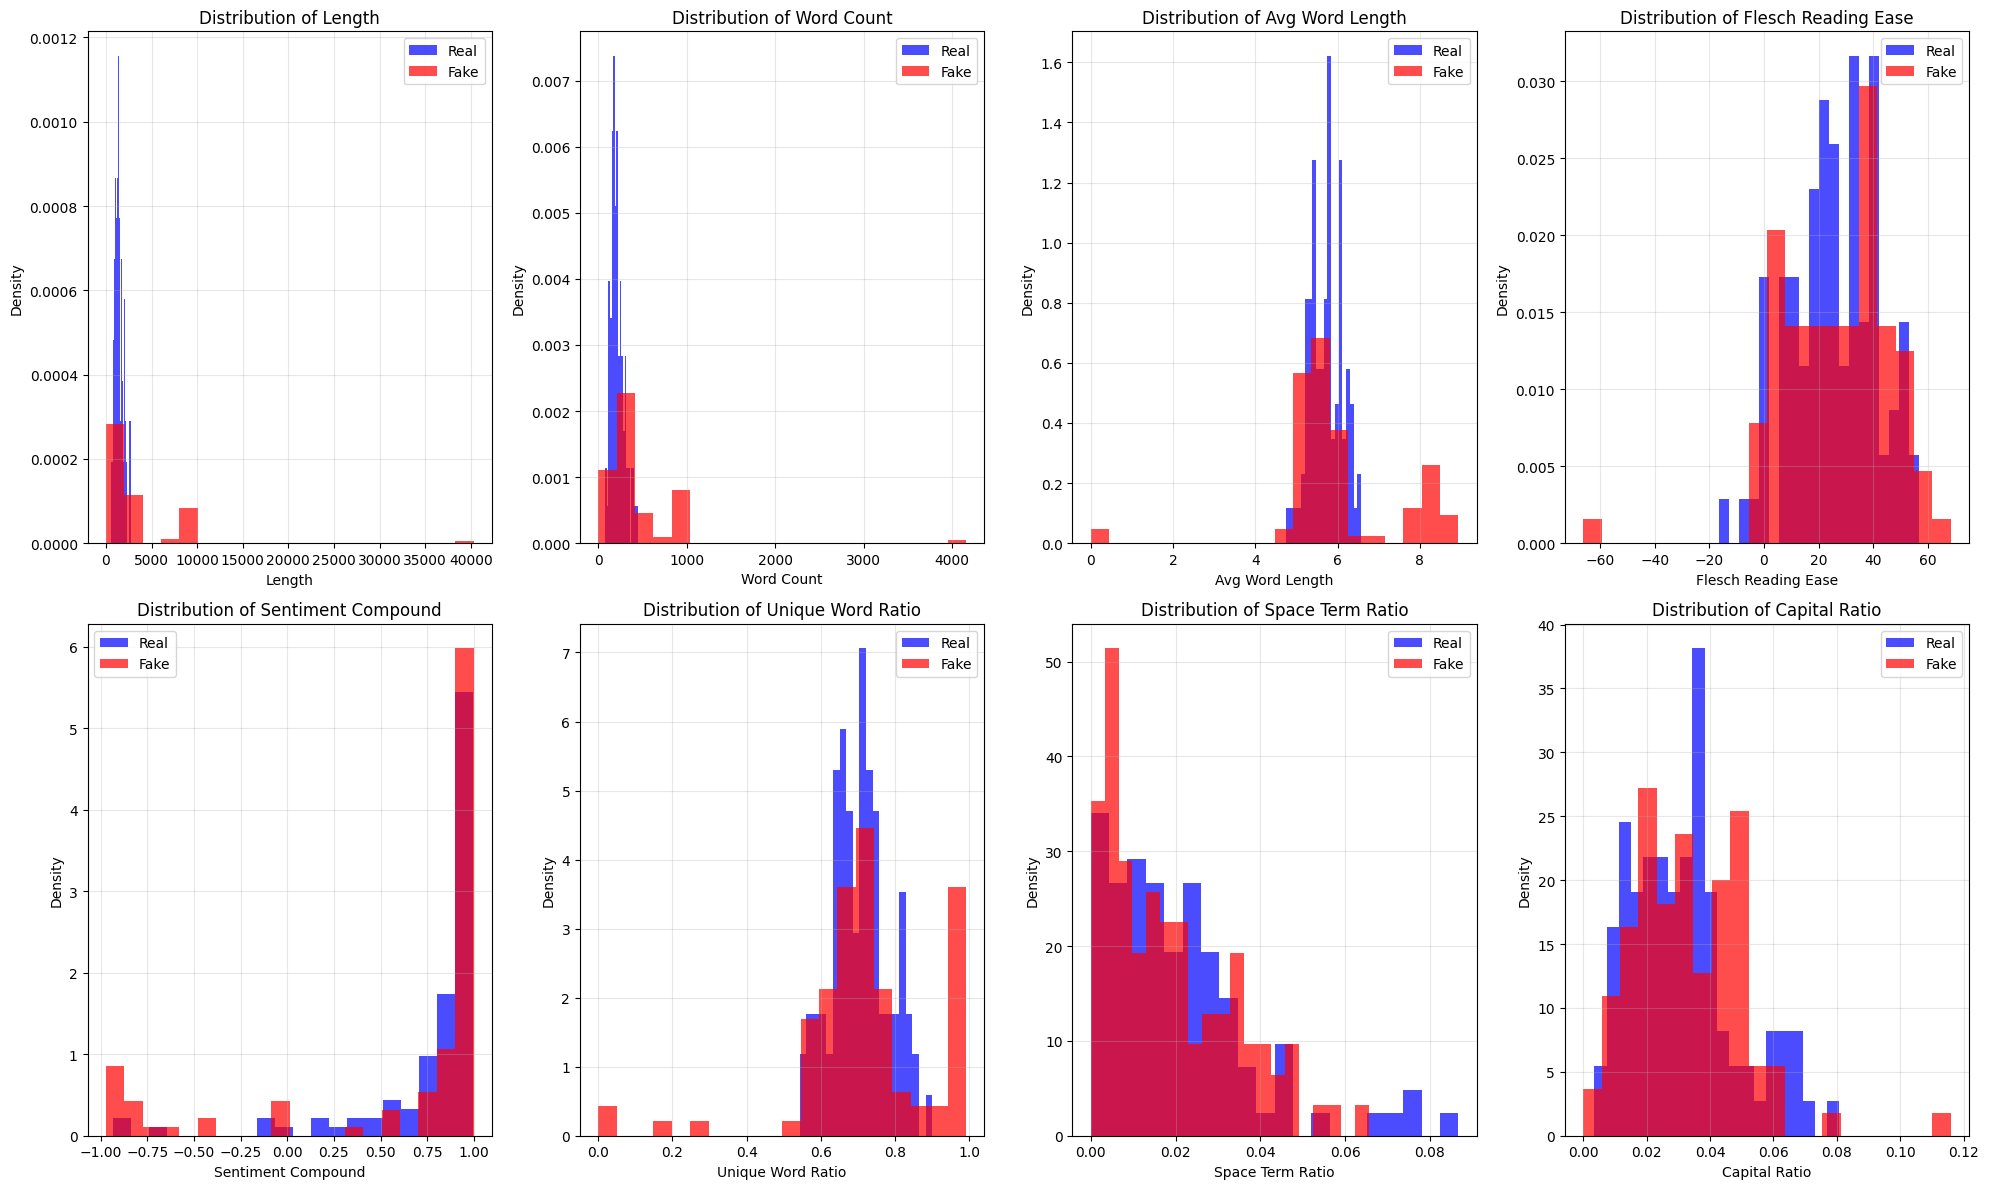


📈 Statistical Comparison (Real vs Fake):
length               | Real: 1446.179 | Fake: 3420.642 | Diff:  -57.7%
word_count           | Real:  216.126 | Fake:  428.053 | Diff:  -49.5%
avg_word_length      | Real:    5.723 | Fake:    5.986 | Diff:   -4.4%
flesch_reading_ease  | Real:   25.649 | Fake:   26.798 | Diff:   -4.3%
sentiment_compound   | Real:    0.760 | Fake:    0.584 | Diff:   30.1%
unique_word_ratio    | Real:    0.708 | Fake:    0.719 | Diff:   -1.6%
space_term_ratio     | Real:    0.021 | Fake:    0.019 | Diff:   12.5%
capital_ratio        | Real:    0.032 | Fake:    0.033 | Diff:   -4.1%

🛠️  Preparing training data...
  Processing sample 1/95
  Processing sample 11/95
  Processing sample 21/95
  Processing sample 31/95
  Processing sample 41/95
  Processing sample 51/95
  Processing sample 61/95
  Processing sample 71/95
  Processing sample 81/95
  Processing sample 91/95
✅ Created 90 features
🤖 Training models...
📊 Training data shape: (95, 90)
🎯 Class distribution: [4

In [33]:
main()